In [39]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE




In [40]:
import warnings

warnings.filterwarnings('ignore')

In [41]:
import pandas as pd

df = df = pd.read_csv('data/Autism Dataset for Toddlers.csv')
df.head()


,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [42]:
df.describe()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,527.500000,0.563567,0.448767,0.401328,0.512334,0.524668,0.576850,0.649905,0.459203,0.489564,0.586338,27.867173,5.212524
std,304.407895,0.496178,0.497604,0.490400,0.500085,0.499628,0.494293,0.477226,0.498569,0.500128,0.492723,7.980354,2.907304
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000
25%,264.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,3.000000
50%,527.500000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,30.000000,5.000000
75%,790.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,8.000000
max,1054.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,10.000000


In [43]:
df.isna().any()


Case_No                   False
A1                        False
A2                        False
A3                        False
A4                        False
A5                        False
A6                        False
A7                        False
A8                        False
A9                        False
A10                       False
Age_Mons                  False
Qchat-10-Score            False
Sex                       False
Ethnicity                 False
Jaundice                  False
Family_mem_with_ASD       False
Who completed the test    False
Class/ASD Traits          False
dtype: bool

In [44]:
df.rename(columns={'Class/ASD Traits ': 'Class/ASD Traits'}, inplace=True)

encoder = LabelEncoder()

df['Class/ASD Traits'] = encoder.fit_transform(df['Class/ASD Traits'])
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,0
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,1
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,1
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,1
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,1


# Data Analysis

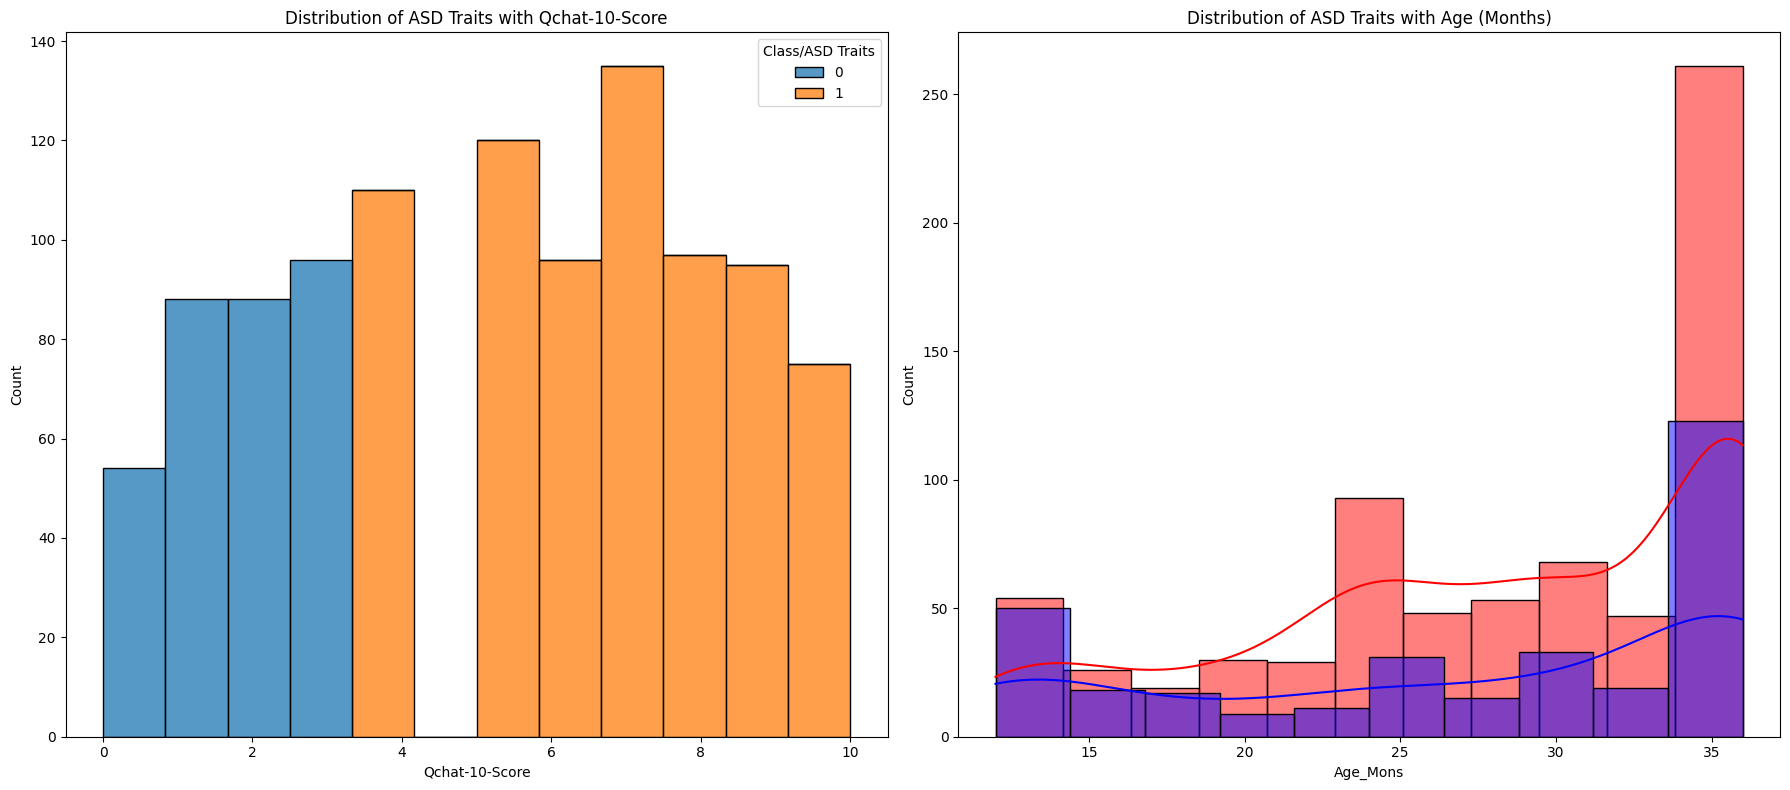

In [45]:
# Divide the DataFrame based on ASD diagnosis
df1 = df[df['Class/ASD Traits'] == 1]
df2 = df[df['Class/ASD Traits'] == 0]

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot distribution of ASD traits with Qchat-10-Score
sb.histplot(data=df, x='Qchat-10-Score', hue='Class/ASD Traits', multiple='stack', ax=axes[0])
axes[0].set_title('Distribution of ASD Traits with Qchat-10-Score')

# Plot distribution of ASD traits with age_mons
sb.histplot(data=df1, x='Age_Mons', color='red', label='ASD Traits', kde=True, ax=axes[1])
sb.histplot(data=df2, x='Age_Mons', color='blue', label='Non ASD Traits', kde=True, ax=axes[1])
axes[1].set_title('Distribution of ASD Traits with Age (Months)')

plt.tight_layout()
plt.show()

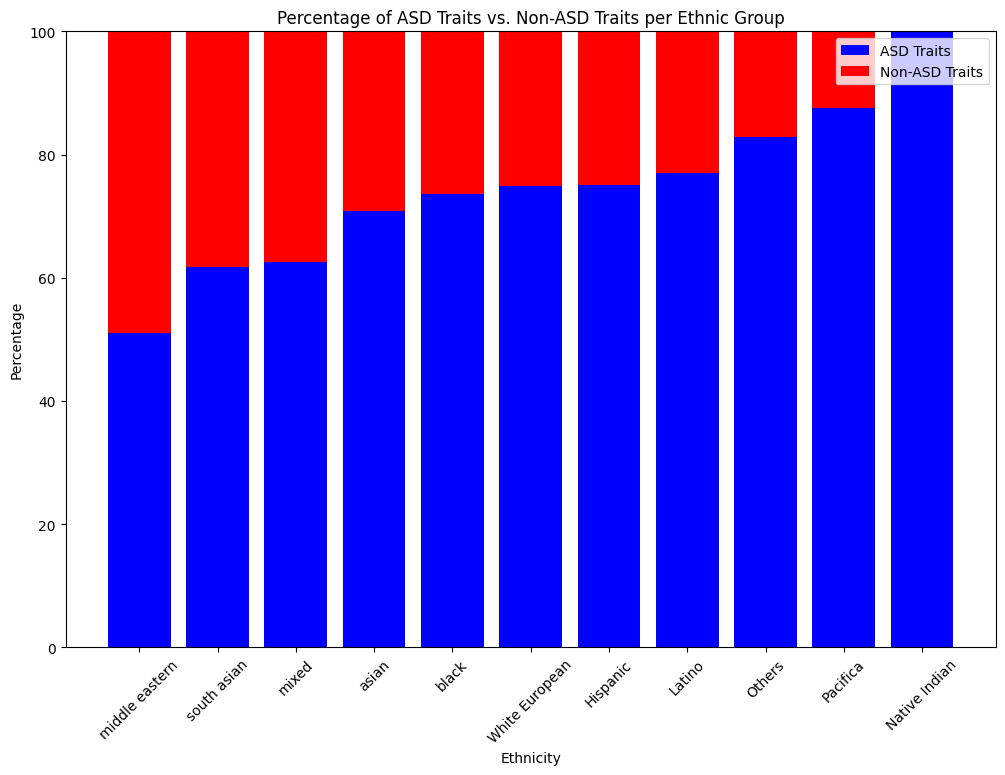

In [46]:
import matplotlib.pyplot as plt
import seaborn as sb

# Calculate the percentage of ASD traits vs. non-ASD traits per ethnic group
ethnicity_counts = df.groupby(['Ethnicity', 'Class/ASD Traits']).size().unstack()
total_counts = ethnicity_counts.sum(axis=1)
percentage_asd = (ethnicity_counts[1] / total_counts) * 100
percentage_non_asd = (ethnicity_counts[0] / total_counts) * 100

# Sort the ethnic groups by percentage of individuals with ASD traits
sorted_indices = percentage_asd.sort_values().index

# Plot the stacked bar plot with sorted ethnic groups
plt.figure(figsize=(12, 8))
p1 = plt.bar(sorted_indices, percentage_asd[sorted_indices], color='b', label='ASD Traits')
p2 = plt.bar(sorted_indices, percentage_non_asd[sorted_indices], bottom=percentage_asd[sorted_indices], color='r', label='Non-ASD Traits')
plt.title('Percentage of ASD Traits vs. Non-ASD Traits per Ethnic Group')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend()
plt.show()


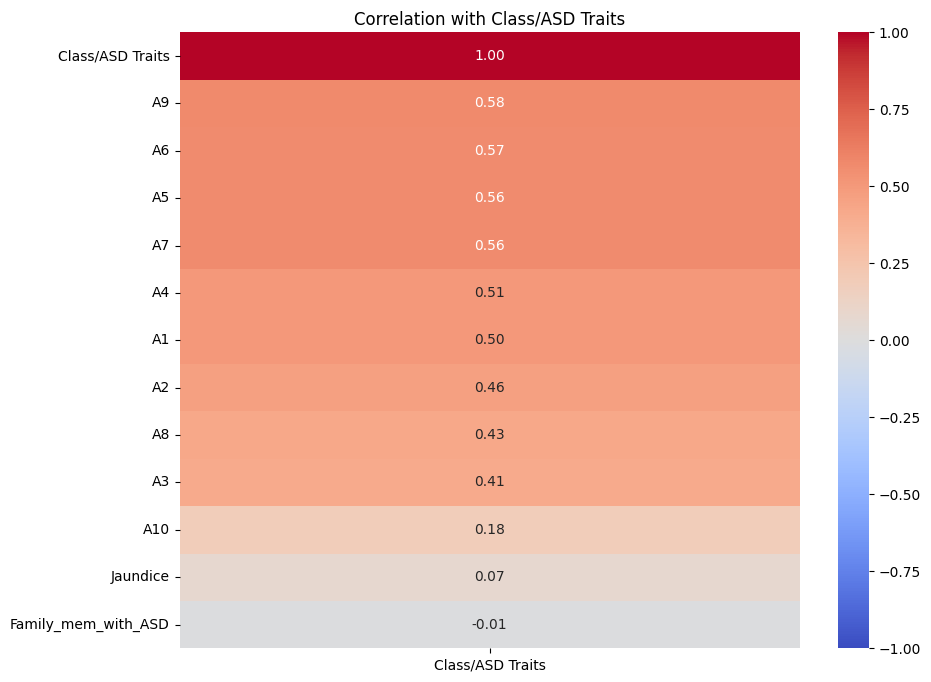

In [47]:
# Encode categorical variables 'Jaundice' and 'Family_mem_with_ASD'
df['Jaundice'] = encoder.fit_transform(df['Jaundice'])
df['Family_mem_with_ASD'] = encoder.fit_transform(df['Family_mem_with_ASD'])

# Create correlation matrix
correlation = df[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'Jaundice', 'Family_mem_with_ASD','Class/ASD Traits']].corr()['Class/ASD Traits'].sort_values(ascending=False)

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation with Class/ASD Traits')
plt.show()


# Prepare data to train model

In [48]:
# Drop non-numeric features
prepared_df = df.drop(['Qchat-10-Score','Case_No', 'Sex', 'Ethnicity', 'Who completed the test'], axis=1)

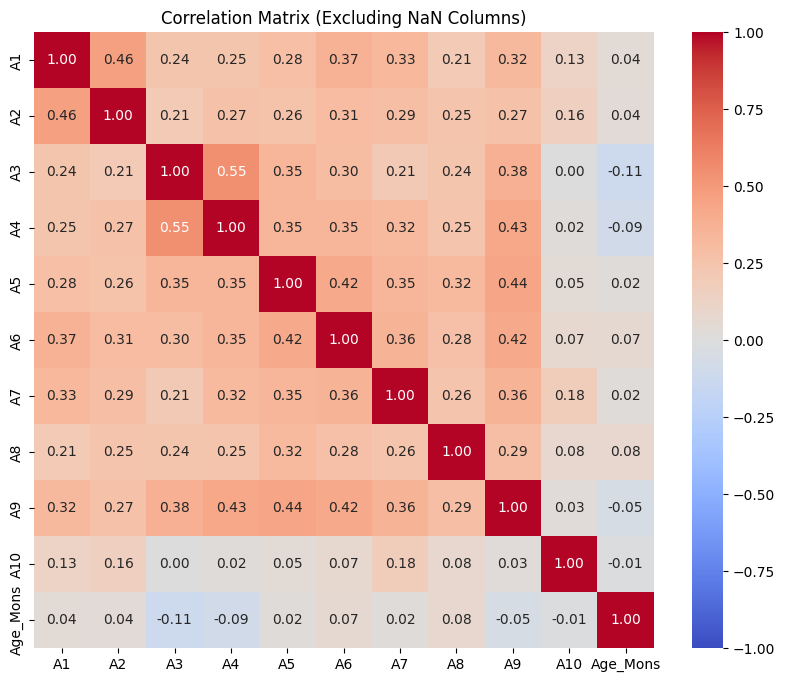

In [49]:
correlation_df = prepared_df.drop(['Jaundice','Family_mem_with_ASD','Class/ASD Traits'], axis=1)

# Calculate correlation matrix
correlation_matrix = correlation_df.corr()


# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix (Excluding NaN Columns)')
plt.show()

In [50]:
# Define the correlation threshold
threshold = 0.95

# Create an empty list to store highly correlated feature pairs
highly_correlated_pairs = []

# Iterate through the correlation matrix to find highly correlated feature pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            highly_correlated_pairs.append((feature1, feature2))

# Print highly correlated feature pairs
if len(highly_correlated_pairs) > 0:
    print("Highly correlated feature pairs:")
    for pair in highly_correlated_pairs:
        print(pair)
else:
    print("No highly correlated feature pairs found.")

No highly correlated feature pairs found.


In [51]:
features = prepared_df.drop(['Class/ASD Traits'],axis=1)
target = df['Class/ASD Traits']

unique_values, counts = np.unique(target, return_counts=True)

print(f"{counts[0]} negative results!")
print(f"{counts[1]} positive results!")

326 negative results!
728 positive results!


Oversampling

In [52]:
# Check for NaN values in the features DataFrame
nan_columns = features.columns[features.isna().any()].tolist()

# Print columns with NaN values
if nan_columns:
    print("Columns with NaN values:")
    for column in nan_columns:
        print(column)
else:
    print("No NaN values found in the DataFrame.")

# Filter the DataFrame to show rows where NaN values occur in 'Jaundice' or 'Family_mem_with_ASD' columns
rows_with_nan = prepared_df[prepared_df[['Jaundice', 'Family_mem_with_ASD']].isna().any(axis=1)]

# Print the rows
print(rows_with_nan)

No NaN values found in the DataFrame.
Empty DataFrame
Columns: [A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, Age_Mons, Jaundice, Family_mem_with_ASD, Class/ASD Traits]
Index: []


In [53]:
smote = SMOTE(random_state=420)

# Oversample the dataset
features_resampled, target_resampled = smote.fit_resample(features, target)

unique_values, counts = np.unique(target_resampled, return_counts=True)

print(f"Number of negative results after SMOTE: {counts[0]}")
print(f"Number of positive results after SMOTE: {counts[1]}")

Number of negative results after SMOTE: 728
Number of positive results after SMOTE: 728


In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=420)

In [55]:
# Step 2: Selecting Algorithms
# Initialize classifiers
dt_classifier = DecisionTreeClassifier()
mlp_classifier = MLPClassifier()
knn_classifier = KNeighborsClassifier()

# Step 3: Training Models
dt_classifier.fit(X_train, y_train)
mlp_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)

# Step 4: Model Evaluation
classifiers = {
    'Decision Tree': dt_classifier,
    'Multi-layer Perceptron': mlp_classifier,
    'k-Nearest Neighbors': knn_classifier
}

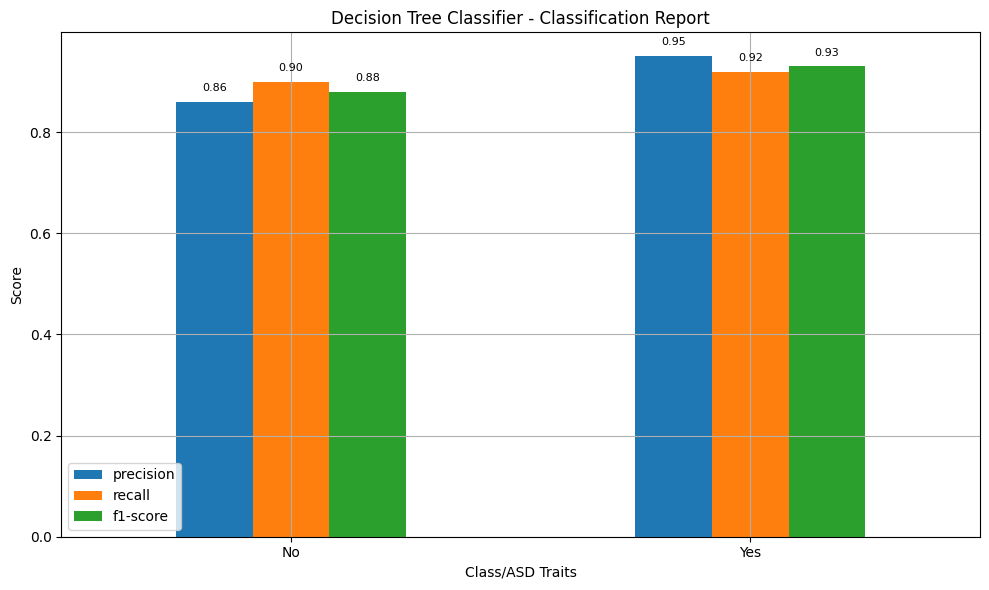

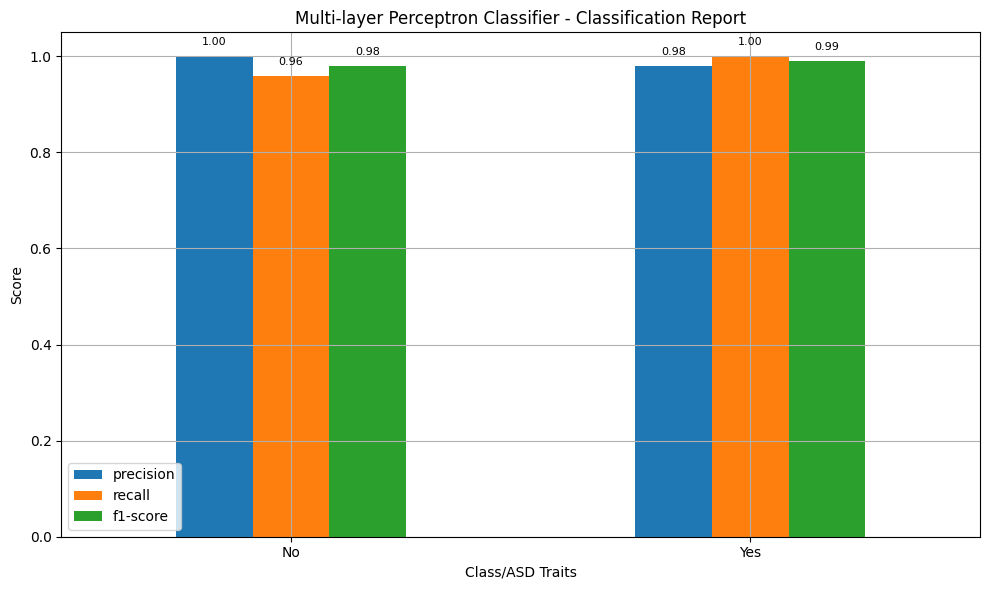

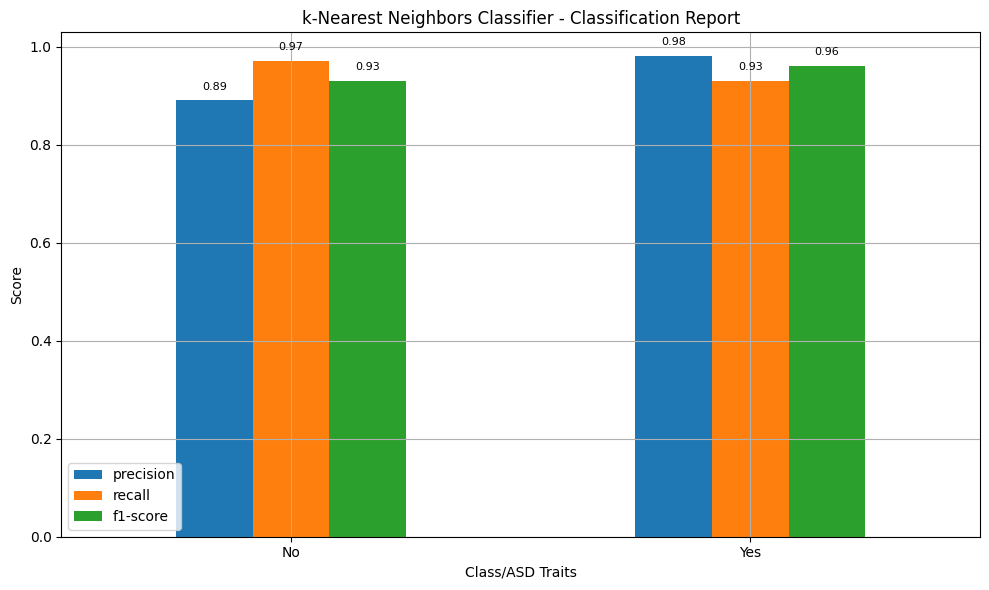

In [56]:
# Plot classification report for each classifier
for name, classifier in classifiers.items():
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred)
    title = f'{name} Classifier - Classification Report'
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split()
        row['class'] = 'Yes' if row_data[0] == '1' else 'No'
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1-score'] = float(row_data[3])
        report_data.append(row)
    df = pd.DataFrame(report_data)
    df.set_index('class', inplace=True)
    ax = df.plot(kind='bar', figsize=(10, 6))

    # Add value annotations on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

    plt.title(title)
    plt.xlabel('Class/ASD Traits')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()


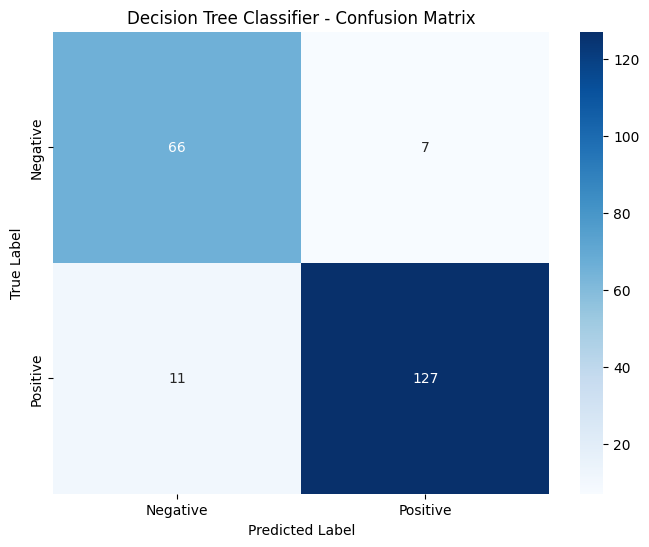

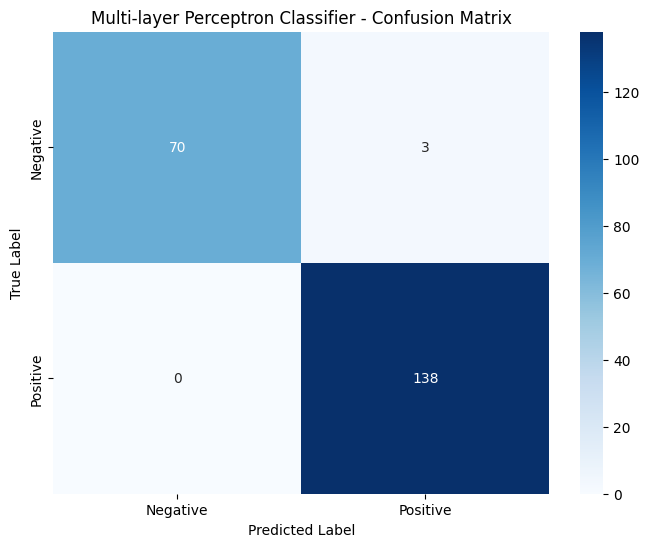

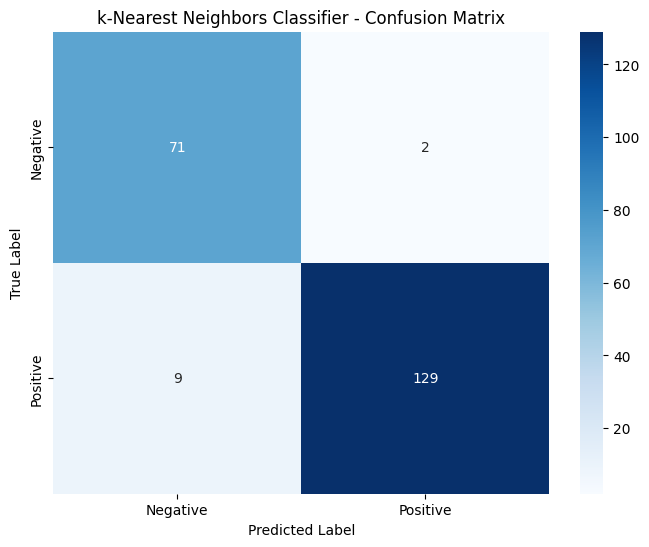

In [57]:
# Plot confusion matrix for each classifier
for name, classifier in classifiers.items():
    y_pred = classifier.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    title = f'{name} Classifier - Confusion Matrix'
    plt.figure(figsize=(8, 6))
    labels = ['Negative', 'Positive']
    sb.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()